In [1]:
import tqdm
import math
import torch
import qpytorch
from matplotlib import pyplot as plt

# Make plots inline
%matplotlib inline

## SVQEP Model Updating

In this notebook, we will be describing a "fantasy model" strategy for stochastic variational QEPs (SVQEPs) analogous to fantasy modelling for exact QEPs. 

To understand what a "fantasy model" is, we first think about exact QEPs. Imagine, we have trained a QEP on some data $\mathcal{D} := \{x_i, y_i\}_{i=1}^N$, which is the same as saying that $\mathbf{y} \sim \mathcal{QEP}(\mu(\mathbf{x}), K(\mathbf{x}, \mathbf{x}'))$. 

If we observe some new data $\mathcal{D}^*:= \{x_j, y_j\}_{j=1}^{N^*}$, then that data is easily incorporated into our QEP model as $(\mathbf{y}, \mathbf{y}^*) \sim \mathcal{QEP}(\mu([\mathbf{x}, \mathbf{x}^*]), K([\mathbf{x}, \mathbf{x}^*], [\mathbf{x}, \mathbf{x}^*]')$.
To compute predictions with this new model (conditional on the same hyper-parameters), we could use the following piece of code for an exact QEP:

```python
updated_model = deepcopy(model)
updated_model.set_train_data(torch.cat((train_x, new_x)), torch.cat((train_y, new_y)), strict=False)
```

or we could take advantage of linear algebraic identies to efficiently produce the same model, which is the `get_fantasy_model` function for exact QEPs in QPyTorch:
```python
updated_model = model.get_fantasy_model(new_x, new_y)
```

The second approach is significantly more computationally efficient, costing $\mathcal{O}((N^*)^2 N)$ time versus $\mathcal{O}((N + N^*)^3)$ time.

In this tutorial notebook, we describe the **online variational conditioning** (OVC) approach of [Maddox et al, '21](https://arxiv.org/abs/2110.15172) which provides a closed form method for updating SVQEPs in the same manner as exact QEPs are updated with respect ot new data, via the usage of the `get_fantasy_model` method.

### Training Data

First, we construct some training data, here $250$ data points from a noisy sine wave.

Text(0, 0.5, 'y')

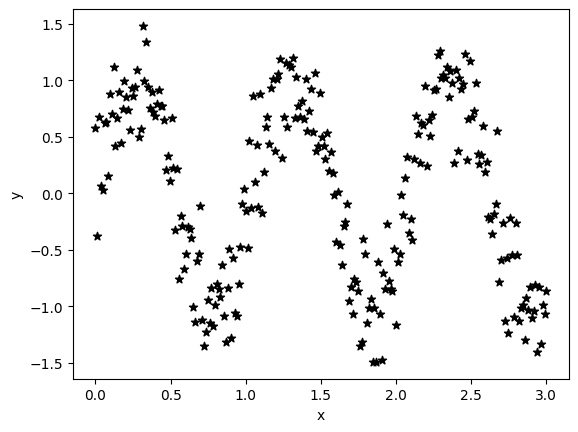

In [2]:
train_x = torch.linspace(0, 3, 250).view(-1, 1).contiguous()
train_y = torch.sin(6. * train_x) + 0.3 * torch.randn_like(train_x)

plt.scatter(train_x, train_y, marker = "*", color = "black")
plt.xlabel("x")
plt.ylabel("y")

### Model definition

Next, we define our model class definition. The only difference from a standard approximate QEP is that we require the likelihood object to be a) Gaussian (for now) and b) to be stored inside of the `ApproximateQEP` object.

In [3]:
from qpytorch.models import ApproximateQEP
from qpytorch.variational import CholeskyVariationalDistribution
from qpytorch.variational import VariationalStrategy
POWER = 1.0

class QEPModel(ApproximateQEP):
    def __init__(self, inducing_points, likelihood):
        self.power = torch.tensor(POWER)
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0), power=self.power)
        variational_strategy = VariationalStrategy(self, inducing_points, variational_distribution, learn_inducing_locations=True)
        super(QEPModel, self).__init__(variational_strategy)
        self.mean_module = qpytorch.means.ConstantMean()
        self.covar_module = qpytorch.kernels.ScaleKernel(qpytorch.kernels.RBFKernel())
        self.likelihood = likelihood
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return qpytorch.distributions.MultivariateQExponential(mean_x, covar_x, power=self.power)

We initialize the SVQEP with $25$ inducing points.

In [4]:
likelihood = qpytorch.likelihoods.QExponentialLikelihood(power=torch.tensor(POWER))
model = QEPModel(torch.randn(25, 1) + 2., likelihood)


### Model Training

As we don't have a lot of data, we train the model with full-batch (although this isn't a restriction) and for $500$ iterations (b/c our choice of inducing points may not have been very good).

In [28]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    # {'params': likelihood.parameters()},
], lr=0.1)

# Our loss object. We're using the VariationalELBO
mll = qpytorch.mlls.VariationalELBO(likelihood, model, num_data=train_y.size(0))

In [29]:
iters = 500 + 1

for i in range(iters):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y.squeeze())
    loss.backward()
    optimizer.step()
    if i % 50 == 0:
        print("Iteration: ", i, "\t Loss:", loss.item())

Iteration:  0 	 Loss: 0.7646129131317139
Iteration:  50 	 Loss: 0.7336000800132751
Iteration:  100 	 Loss: 0.718480110168457
Iteration:  150 	 Loss: 0.7089231014251709
Iteration:  200 	 Loss: 0.7016969323158264
Iteration:  250 	 Loss: 0.6985439658164978
Iteration:  300 	 Loss: 0.6927851438522339
Iteration:  350 	 Loss: 0.69287109375
Iteration:  400 	 Loss: 0.7060893774032593
Iteration:  450 	 Loss: 0.6896464824676514
Iteration:  500 	 Loss: 0.6860941648483276


### Model Evaluation

Now, that we've trained our SVQEP, we choose some data to evaluate it on -- here $250$ data points from $[0, 8]$ to illustrate the performance both for interpolation (on $[0,3]$) and extrapolation (on $[3, 8]$).

In [32]:
model.eval()
likelihood.eval()

test_x = torch.linspace(0, 8, 250).view(-1,1)
with torch.no_grad():
    posterior = likelihood(model(test_x))

As expected, the posterior model fits the training data well but reverts to a zero mean and high prediction outside of the region of the training data.

Text(0, 0.5, 'y')

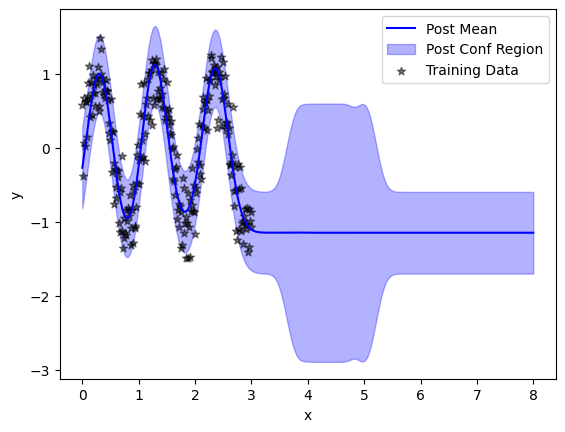

In [33]:
plt.plot(test_x, posterior.mean, color = "blue", label = "Post Mean")
plt.fill_between(test_x.squeeze(), *posterior.confidence_region(), color = "blue", alpha = 0.3, label = "Post Conf Region")
plt.scatter(train_x, train_y, color = "black", marker = "*", alpha = 0.5, label = "Training Data")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

### Model Updating

Now, we choose $25$ points to condition the model on -- imagining that these data points have just been acquired, perhaps from an active learning or Bayesian optimization loop.

In [34]:
val_x = torch.linspace(3, 5, 25).view(-1,1)
val_y = torch.sin(6. * val_x) + 0.3 * torch.randn_like(val_x)

In [35]:
cond_model = model.variational_strategy.get_fantasy_model(inputs=val_x, targets=val_y.squeeze())

Note that the updated model returned is an ExactQEP class rather than a SVQEP.

In [36]:
cond_model

_BaseExactQEP(
  (likelihood): QExponentialLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)

We compute its posterior distribution on the same testing dataset as before.

In [37]:
with torch.no_grad():
    updated_posterior = cond_model.likelihood(cond_model(test_x))

Finally, we plot the updated model, showing that the model has been updated to the newly observed data (grey) without forgetting the previous training data (black).

Text(0, 0.5, 'y')

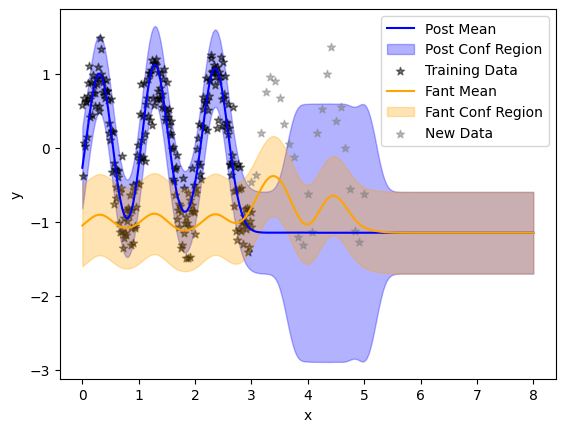

In [38]:
plt.plot(test_x, posterior.mean, color = "blue", label = "Post Mean")
plt.fill_between(test_x.squeeze(), *posterior.confidence_region(), color = "blue", alpha = 0.3, label = "Post Conf Region")
plt.scatter(train_x, train_y, color = "black", marker = "*", alpha = 0.5, label = "Training Data")

plt.plot(test_x, updated_posterior.mean, color = "orange", label = "Fant Mean")
plt.fill_between(test_x.squeeze(), *updated_posterior.confidence_region(), color = "orange", alpha = 0.3, label = "Fant Conf Region")

plt.scatter(val_x, val_y, color = "grey", marker = "*", alpha = 0.5, label = "New Data")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")